# Top overlapping annotations by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


<Axes: >

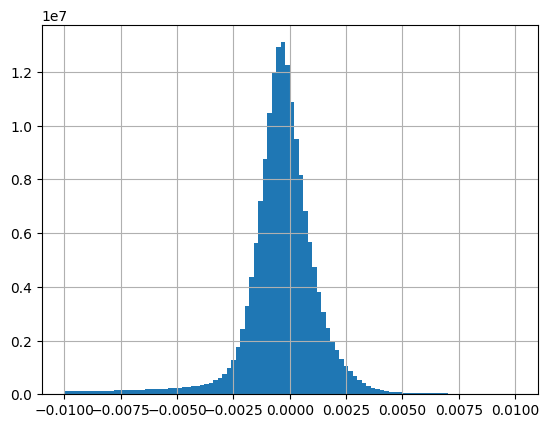

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [5]:
len(bedDf.tokens.unique())

3894

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [8]:
len(highscoreDf.tokens.unique())

1991

In [9]:
highscoreDf.shape

(286987, 7)

<Axes: >

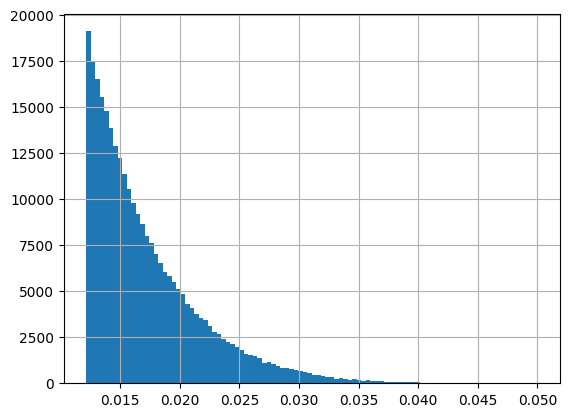

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

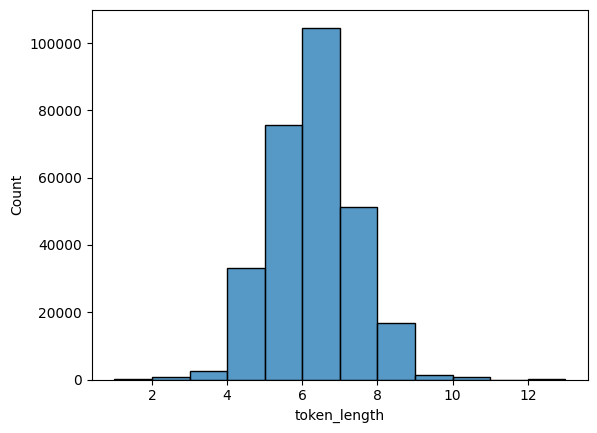

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read core genes

In [15]:
import os
from pathlib import Path

import pandas as pd


coreGenesPath = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 's_aureus', 'panaroo_strict', 'core_genes.csv')
coreGenesDf = pd.read_csv(coreGenesPath)
coreGenesDf['Gene'] = coreGenesDf.Gene.str.lower()
coreGenesDf

,Gene,Occurrences
0,hslo,557
1,metg,557
2,spovg,557
3,holb,557
4,rsma,557
...,...,...
2169,group_1798,535
2170,group_2151,534
2171,scn,534
2172,group_1944,532


## Read bed files containing overlapping tokens and attribution scores

In [16]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    coreDf = df[df.gene.isin(coreGenesDf.Gene)]
    annotationOverlappingDfList.append(coreDf)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

 13%|█▎        | 66/515 [01:24<09:21,  1.25s/it]/tmp/ipykernel_7620/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [02:40<06:56,  1.06s/it]/tmp/ipykernel_7620/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [03:46<07:01,  1.23s/it]/tmp/ipykernel_7620/4256423940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,6,1,156,160,GTTGA,-0.016608,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,8,1,164,169,TTTAGG,-0.011910,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,9,1,170,175,TGTAGA,0.002626,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
82489752,337313,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
82489753,337314,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
82489754,337315,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
82489755,337316,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI00

In [17]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf['Gene symbol'] = amrOverlappingDf['Gene symbol'].str.lower()
amrOverlappingDf

  1%|          | 4/557 [00:00<00:16, 33.78it/s]

100%|██████████| 557/557 [00:10<00:00, 52.34it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blar1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepa,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


In [18]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,138,145,AAAGTAAA,0.009005,acpp,acyl carrier protein,AH20I016
1,1,146,151,AGATAT,-0.010377,acpp,acyl carrier protein,AH20I016
2,1,156,160,GTTGA,-0.016608,acpp,acyl carrier protein,AH20I016
3,1,164,169,TTTAGG,-0.011910,acpp,acyl carrier protein,AH20I016
4,1,170,175,TGTAGA,0.002626,acpp,acyl carrier protein,AH20I016
...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,mepa,multidrug efflux MATE transporter MepA,AH20L076
1607,3,313975,313979,CTTTG,0.014194,mepa,multidrug efflux MATE transporter MepA,AH20L076
1608,3,314026,314030,ACAGT,0.012561,mepa,multidrug efflux MATE transporter MepA,AH20L076
1609,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044


## Get overlapping genes for high-score tokens

In [19]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
1,1,302,309,AAAAATCA,0.012217,acpp,acyl carrier protein,AH20I016
2,1,483,491,AAAGAAAAG,0.018888,rnc,ribonuclease III,AH20I016
3,1,604,608,AATGA,0.015653,rnc,ribonuclease III,AH20I016
4,1,609,615,TTTTAAT,0.018532,rnc,ribonuclease III,AH20I016
...,...,...,...,...,...,...,...,...
209187,3,313975,313979,CTTTG,0.014194,mepa,multidrug efflux MATE transporter MepA,AH20L076
209188,3,314026,314030,ACAGT,0.012561,mepa,multidrug efflux MATE transporter MepA,AH20L076
209189,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044
209190,5,67876,67879,TTGA,0.013503,blai,penicillinase repressor BlaI,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [20]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_7620/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x788a541343a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,aaa,1.831435
1,abgb,6.237819
2,abrb,2.703959
3,acca,1.785996
4,accb,2.941337
...,...,...
1428,zapa,1.286040
1429,znua,9.320601
1430,znub,4.685461
1431,znuc,3.138582


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

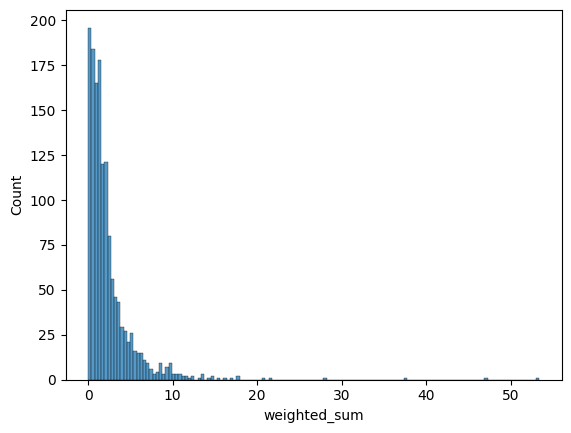

In [21]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [22]:
weightedsumCutoff = geneWeightedsumDf.weighted_sum.mean() + (2 * geneWeightedsumDf.weighted_sum.std())
weightedsumCutoff

np.float64(9.06096229209766)

In [23]:
geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)

,gene,weighted_sum
276,essc,53.386270
377,gltb,46.922011
337,ftsk,37.587255
90,bglg,28.027139
851,ptsg,21.585067
892,qri1,20.626175
813,polc,17.918393
121,ccma,17.915418
1050,sbcc,16.813448
10,acoa,16.322731


## Create gene-type lookup table from amrfinderplus annotations

In [24]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_7620/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [25]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [26]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [27]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [28]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [29]:
import pandas as pd

pd.set_option('display.max_rows', None)


geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates(subset=['gene', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type'])

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,essc,type VII secretion system protein EssC%2C FtsK/SpoIIIE family ATPase,53.386270,NaN,NaN,NaN
2,gltb,glutamate synthase large subunit,46.922011,NaN,NaN,NaN
3,ftsk,DNA segregation ATPase FtsK/SpoIIIE or related protein,37.587255,NaN,NaN,NaN
5,bglg,Transcriptional antiterminator,28.027139,NaN,NaN,NaN
7,ptsg,PTS system glucose-specific EIICBA component,21.585067,NaN,NaN,NaN
9,qri1,putative uridylyltransferase MW2097,20.626175,NaN,NaN,NaN
10,polc,PolC-type DNA polymerase III,17.918393,NaN,NaN,NaN
11,ccma,ABC-type multidrug transport system%2C ATPase component,17.915418,NaN,NaN,NaN
13,sbcc,Nuclease SbcCD subunit C,16.813448,NaN,NaN,NaN
14,acoa,TPP-dependent pyruvate or acetoin dehydrogenase subunit alpha,16.322731,NaN,NaN,NaN


## Save all gene hits

In [30]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [31]:
import pandas as pd

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [32]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [33]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [34]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [35]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [36]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [37]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [38]:
geneWeightedsumDf

,gene,weighted_sum
0,aaa,1.831435
1,abgb,6.237819
2,abrb,2.703959
3,acca,1.785996
4,accb,2.941337
...,...,...
1428,zapa,1.286040
1429,znua,9.320601
1430,znub,4.685461
1431,znuc,3.138582


In [39]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf[geneWeightedsumDf.weighted_sum > weightedsumCutoff].sort_values(by=['weighted_sum'], ascending=False)['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
50,1,104059,104064,GATGTG,0.027761,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
51,1,104122,104128,AAAATGG,0.014966,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
52,1,104373,104377,TTTGT,0.016255,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
53,1,104463,104469,CCAACAT,0.020258,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
54,1,104625,104630,AATGAT,0.014629,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
...,...,...,...,...,...,...,...,...
209118,1,358534,358539,TAAAGG,0.013273,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
209119,1,358734,358737,AACC,0.015188,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
209120,1,358845,358851,CTATAAA,0.016098,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
209121,1,358993,358997,CATGA,0.013797,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011


In [40]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acef,acoa,acob,arac,azor,bglg,ccdc,ccma,coba,...,sbcd,sfca,tdh,tet(38),trec,typa,uhpt,walk,yqfa,znua
50,AH20I016,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
148,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
477,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208793,ALF22I018,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
208888,AH21E078,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
209027,AH19F054,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
209085,AH20B051,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Create datamatrix

In [41]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,acef,acoa,acob,arac,azor,bglg,...,sbcd,sfca,tdh,tet(38),trec,typa,uhpt,walk,yqfa,znua
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [42]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,acef,acoa,acob,arac,azor,bglg,ccdc,ccma,...,sbcd,sfca,tdh,tet(38),trec,typa,uhpt,walk,yqfa,znua
death_30_day,0.565178,1.000000,0.004872,0.004872,0.004872,-0.005096,0.006906,-0.006259,0.032582,-0.017908,...,-0.003593,0.004872,-0.026451,0.020556,0.015880,-0.050389,0.004872,-0.005096,-0.039769,0.014108
death_7_day,1.000000,0.565178,-0.020092,0.040727,0.040727,0.006720,0.057727,-0.007548,0.031953,0.016021,...,-0.022476,-0.020092,-0.030223,0.045316,0.052799,-0.028479,-0.020092,-0.031876,-0.022476,-0.026624
pepf,0.091759,0.081646,-0.006745,-0.006745,-0.006745,-0.010701,-0.009561,-0.013144,-0.007546,-0.018092,...,-0.007546,-0.006745,-0.010147,-0.010701,-0.005838,-0.009561,-0.006745,-0.010701,-0.007546,-0.008938
ptsg,0.064451,0.047478,-0.010118,-0.010118,-0.010118,-0.016053,-0.014342,-0.019716,-0.011319,-0.027138,...,-0.011319,-0.010118,-0.015220,-0.016053,-0.008758,-0.014342,-0.010118,-0.016053,-0.011319,-0.013408
era,0.003370,0.038702,-0.007466,-0.007466,-0.007466,-0.011844,-0.010582,-0.014547,-0.008352,-0.020024,...,-0.008352,-0.007466,-0.011230,-0.011844,-0.006462,-0.010582,-0.007466,-0.011844,-0.008352,-0.009893
gltb,0.057727,0.035553,-0.006356,-0.006356,-0.006356,-0.010084,-0.009009,-0.012385,-0.007110,-0.017047,...,-0.007110,-0.006356,-0.009561,-0.010084,-0.005501,-0.009009,-0.006356,-0.010084,-0.007110,-0.008422
iles,0.057727,0.035553,-0.006356,-0.006356,-0.006356,-0.010084,-0.009009,-0.012385,-0.007110,-0.017047,...,-0.007110,-0.006356,-0.009561,-0.010084,-0.005501,-0.009009,-0.006356,-0.010084,-0.007110,-0.008422
sbcc,0.031953,0.032582,-0.005016,-0.005016,-0.005016,-0.007958,-0.007110,-0.009775,-0.005612,-0.013454,...,-0.005612,-0.005016,-0.007546,-0.007958,-0.004342,-0.007110,-0.005016,-0.007958,-0.005612,-0.006647
ccdc,0.031953,0.032582,-0.005016,-0.005016,-0.005016,-0.007958,-0.007110,-0.009775,1.000000,-0.013454,...,-0.005612,-0.005016,-0.007546,-0.007958,-0.004342,-0.007110,-0.005016,-0.007958,-0.005612,-0.006647
leuc,-0.014191,0.031993,-0.003167,-0.003167,-0.003167,-0.005025,-0.004489,-0.006172,-0.003543,-0.008495,...,-0.003543,-0.003167,-0.004764,-0.005025,-0.002741,-0.004489,-0.003167,-0.005025,-0.003543,-0.004197


### Plot correlations as a heatmap

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'acef'),
 Text(0, 3.5, 'acoa'),
 Text(0, 4.5, 'acob'),
 Text(0, 5.5, 'arac'),
 Text(0, 6.5, 'azor'),
 Text(0, 7.5, 'bglg'),
 Text(0, 8.5, 'ccdc'),
 Text(0, 9.5, 'ccma'),
 Text(0, 10.5, 'coba'),
 Text(0, 11.5, 'deob'),
 Text(0, 12.5, 'ecsb'),
 Text(0, 13.5, 'era'),
 Text(0, 14.5, 'essb'),
 Text(0, 15.5, 'essc'),
 Text(0, 16.5, 'fadb'),
 Text(0, 17.5, 'fdhf'),
 Text(0, 18.5, 'fepd'),
 Text(0, 19.5, 'ftsk'),
 Text(0, 20.5, 'ftsw'),
 Text(0, 21.5, 'fumc'),
 Text(0, 22.5, 'gap'),
 Text(0, 23.5, 'gltb'),
 Text(0, 24.5, 'hara'),
 Text(0, 25.5, 'iles'),
 Text(0, 26.5, 'leuc'),
 Text(0, 27.5, 'lysr'),
 Text(0, 28.5, 'mdlb'),
 Text(0, 29.5, 'mete'),
 Text(0, 30.5, 'miab'),
 Text(0, 31.5, 'ndh'),
 Text(0, 32.5, 'nirb'),
 Text(0, 33.5, 'pepf'),
 Text(0, 34.5, 'polc'),
 Text(0, 35.5, 'pote'),
 Text(0, 36.5, 'pros'),
 Text(0, 37.5, 'ptsg'),
 Text(0, 38.5, 'ptsn'),
 Text(0, 39.5, 'pyca'),
 Text(0, 40.5, 'qri1'),
 Text(0, 41.5,

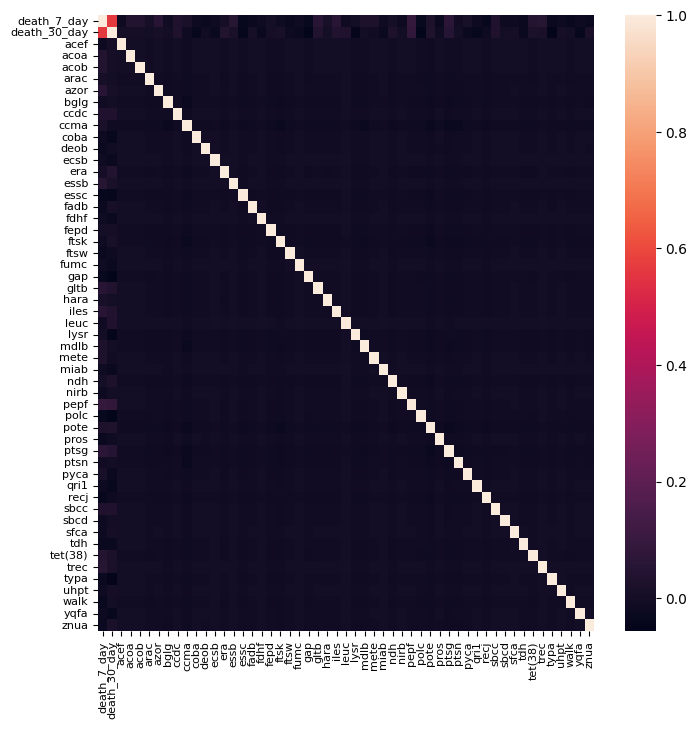

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf)

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'acef'),
 Text(0, 3.5, 'acoa'),
 Text(0, 4.5, 'acob'),
 Text(0, 5.5, 'arac'),
 Text(0, 6.5, 'azor'),
 Text(0, 7.5, 'bglg'),
 Text(0, 8.5, 'ccdc'),
 Text(0, 9.5, 'ccma'),
 Text(0, 10.5, 'coba'),
 Text(0, 11.5, 'deob'),
 Text(0, 12.5, 'ecsb'),
 Text(0, 13.5, 'era'),
 Text(0, 14.5, 'essb'),
 Text(0, 15.5, 'essc'),
 Text(0, 16.5, 'fadb'),
 Text(0, 17.5, 'fdhf'),
 Text(0, 18.5, 'fepd'),
 Text(0, 19.5, 'ftsk'),
 Text(0, 20.5, 'ftsw'),
 Text(0, 21.5, 'fumc'),
 Text(0, 22.5, 'gap'),
 Text(0, 23.5, 'gltb'),
 Text(0, 24.5, 'hara'),
 Text(0, 25.5, 'iles'),
 Text(0, 26.5, 'leuc'),
 Text(0, 27.5, 'lysr'),
 Text(0, 28.5, 'mdlb'),
 Text(0, 29.5, 'mete'),
 Text(0, 30.5, 'miab'),
 Text(0, 31.5, 'ndh'),
 Text(0, 32.5, 'nirb'),
 Text(0, 33.5, 'pepf'),
 Text(0, 34.5, 'polc'),
 Text(0, 35.5, 'pote'),
 Text(0, 36.5, 'pros'),
 Text(0, 37.5, 'ptsg'),
 Text(0, 38.5, 'ptsn'),
 Text(0, 39.5, 'pyca'),
 Text(0, 40.5, 'qri1'),
 Text(0, 41.5,

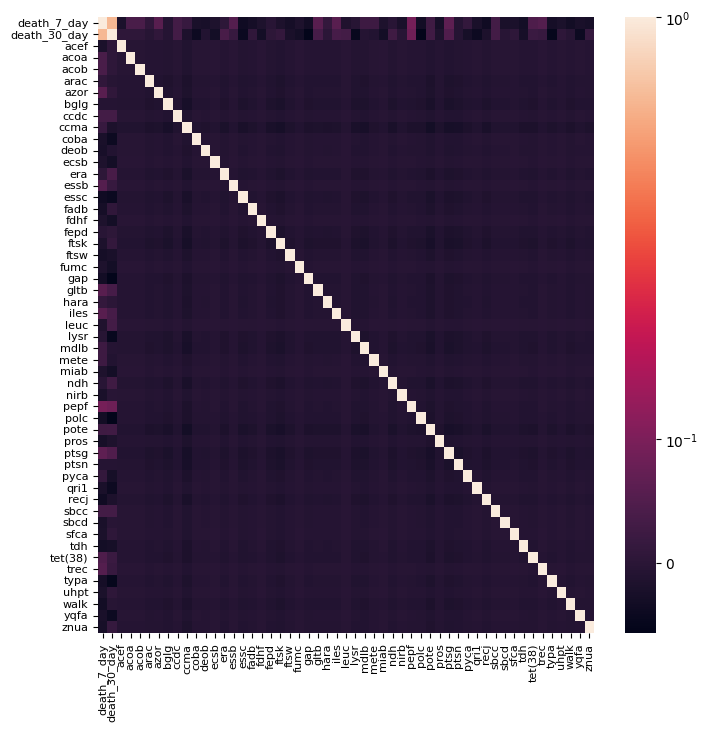

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr()

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'death_30_day'),
 Text(0, 2.5, 'pepf'),
 Text(0, 3.5, 'ptsg'),
 Text(0, 4.5, 'azor'),
 Text(0, 5.5, 'gltb'),
 Text(0, 6.5, 'iles'),
 Text(0, 7.5, 'essb'),
 Text(0, 8.5, 'trec'),
 Text(0, 9.5, 'tet(38)'),
 Text(0, 10.5, 'acob'),
 Text(0, 11.5, 'acoa'),
 Text(0, 12.5, 'sbcc'),
 Text(0, 13.5, 'ccdc'),
 Text(0, 14.5, 'pote'),
 Text(0, 15.5, 'mete'),
 Text(0, 16.5, 'mdlb'),
 Text(0, 17.5, 'ccma'),
 Text(0, 18.5, 'pyca'),
 Text(0, 19.5, 'hara'),
 Text(0, 20.5, 'arac'),
 Text(0, 21.5, 'era'),
 Text(0, 22.5, 'fepd'),
 Text(0, 23.5, 'ndh'),
 Text(0, 24.5, 'lysr'),
 Text(0, 25.5, 'bglg'),
 Text(0, 26.5, 'ptsn'),
 Text(0, 27.5, 'leuc'),
 Text(0, 28.5, 'fumc'),
 Text(0, 29.5, 'ecsb'),
 Text(0, 30.5, 'miab'),
 Text(0, 31.5, 'fdhf'),
 Text(0, 32.5, 'ftsk'),
 Text(0, 33.5, 'acef'),
 Text(0, 34.5, 'sfca'),
 Text(0, 35.5, 'uhpt'),
 Text(0, 36.5, 'nirb'),
 Text(0, 37.5, 'coba'),
 Text(0, 38.5, 'qri1'),
 Text(0, 39.5, 'yqfa'),
 Text(0, 40.5, 'sbcd'),
 Text(0, 4

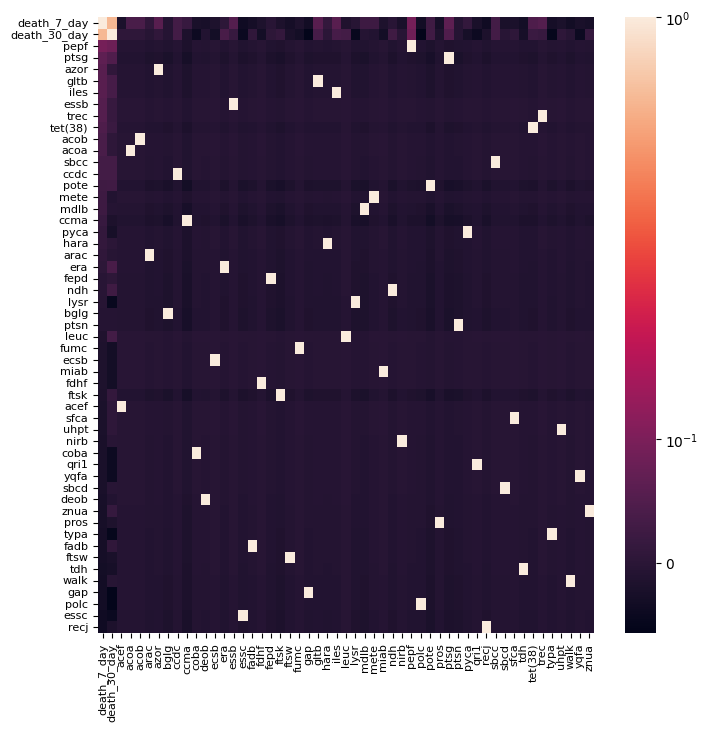

In [45]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 7 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_7_day'),
 Text(0, 1.5, 'pepf'),
 Text(0, 2.5, 'ptsg'),
 Text(0, 3.5, 'azor'),
 Text(0, 4.5, 'gltb'),
 Text(0, 5.5, 'iles'),
 Text(0, 6.5, 'essb'),
 Text(0, 7.5, 'trec'),
 Text(0, 8.5, 'tet(38)'),
 Text(0, 9.5, 'acob'),
 Text(0, 10.5, 'acoa'),
 Text(0, 11.5, 'sbcc'),
 Text(0, 12.5, 'ccdc'),
 Text(0, 13.5, 'pote'),
 Text(0, 14.5, 'mete'),
 Text(0, 15.5, 'mdlb'),
 Text(0, 16.5, 'ccma'),
 Text(0, 17.5, 'pyca'),
 Text(0, 18.5, 'hara'),
 Text(0, 19.5, 'arac'),
 Text(0, 20.5, 'era'),
 Text(0, 21.5, 'fepd'),
 Text(0, 22.5, 'ndh'),
 Text(0, 23.5, 'lysr'),
 Text(0, 24.5, 'bglg'),
 Text(0, 25.5, 'ptsn'),
 Text(0, 26.5, 'leuc'),
 Text(0, 27.5, 'fumc'),
 Text(0, 28.5, 'ecsb'),
 Text(0, 29.5, 'miab'),
 Text(0, 30.5, 'fdhf'),
 Text(0, 31.5, 'ftsk'),
 Text(0, 32.5, 'acef'),
 Text(0, 33.5, 'sfca'),
 Text(0, 34.5, 'uhpt'),
 Text(0, 35.5, 'nirb'),
 Text(0, 36.5, 'coba'),
 Text(0, 37.5, 'qri1'),
 Text(0, 38.5, 'yqfa'),
 Text(0, 39.5, 'sbcd'),
 Text(0, 40.5, 'deob'),
 Text(0, 41.5, 'zn

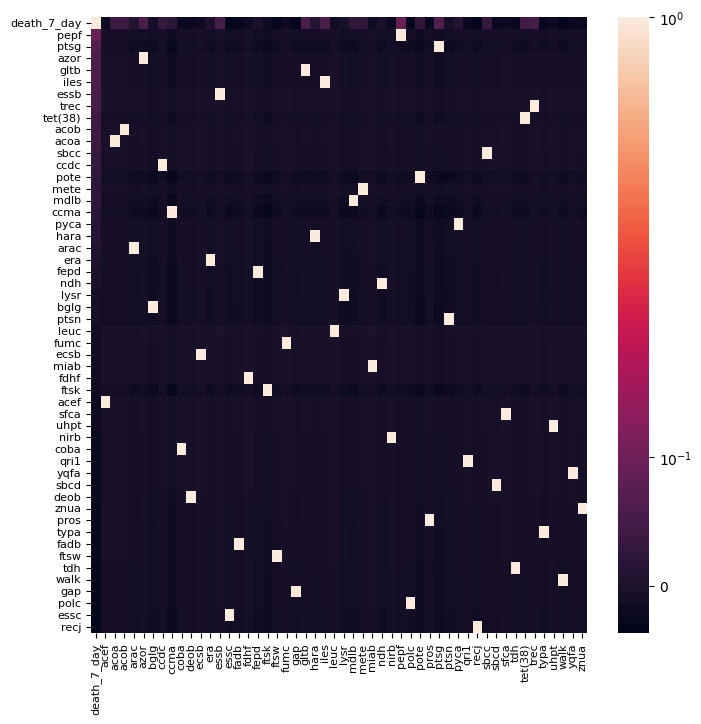

In [46]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day']).corr().sort_values('death_7_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Plot correlations as a heatmap for 30 day mortality target (Log scale - Sorted)

[Text(0, 0.5, 'death_30_day'),
 Text(0, 1.5, 'pepf'),
 Text(0, 2.5, 'ptsg'),
 Text(0, 3.5, 'era'),
 Text(0, 4.5, 'gltb'),
 Text(0, 5.5, 'iles'),
 Text(0, 6.5, 'sbcc'),
 Text(0, 7.5, 'ccdc'),
 Text(0, 8.5, 'leuc'),
 Text(0, 9.5, 'pote'),
 Text(0, 10.5, 'ndh'),
 Text(0, 11.5, 'tet(38)'),
 Text(0, 12.5, 'trec'),
 Text(0, 13.5, 'essb'),
 Text(0, 14.5, 'znua'),
 Text(0, 15.5, 'ftsk'),
 Text(0, 16.5, 'azor'),
 Text(0, 17.5, 'fadb'),
 Text(0, 18.5, 'acef'),
 Text(0, 19.5, 'acob'),
 Text(0, 20.5, 'acoa'),
 Text(0, 21.5, 'sfca'),
 Text(0, 22.5, 'uhpt'),
 Text(0, 23.5, 'fepd'),
 Text(0, 24.5, 'hara'),
 Text(0, 25.5, 'sbcd'),
 Text(0, 26.5, 'nirb'),
 Text(0, 27.5, 'walk'),
 Text(0, 28.5, 'arac'),
 Text(0, 29.5, 'bglg'),
 Text(0, 30.5, 'mdlb'),
 Text(0, 31.5, 'ptsn'),
 Text(0, 32.5, 'mete'),
 Text(0, 33.5, 'deob'),
 Text(0, 34.5, 'pros'),
 Text(0, 35.5, 'ccma'),
 Text(0, 36.5, 'recj'),
 Text(0, 37.5, 'ftsw'),
 Text(0, 38.5, 'tdh'),
 Text(0, 39.5, 'pyca'),
 Text(0, 40.5, 'ecsb'),
 Text(0, 41.5, 'fu

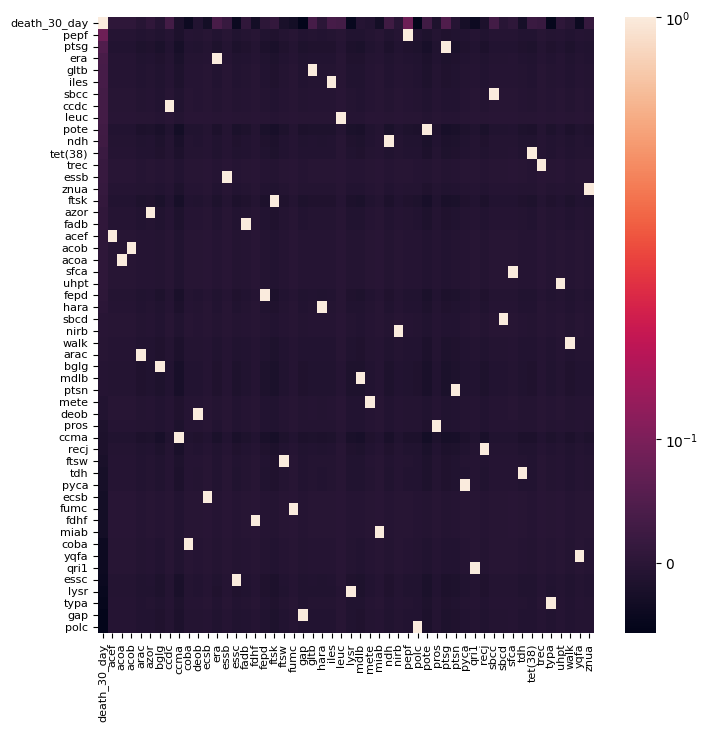

In [47]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm

corrDf = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day']).corr().sort_values('death_30_day', ascending=False)

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(corrDf, norm=SymLogNorm(linthresh=0.3))

ticks = np.arange(corrDf.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corrDf.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corrDf.index, rotation=360, fontsize=8)

### Model using machine learning (7 day mortality)

In [48]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.25555555555555554
Balanced Accuracy:  0.40773809523809523
Average Precision:  0.05780228758169935
F1 Score:  0.0945945945945946
ROC AUC:  0.40773809523809523


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.9333333333333333
Balanced Accuracy:  0.5
Average Precision:  0.06666666666666667
F1 Score:  0.0
ROC AUC:  0.5


In [51]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
17,ftsk,-0.664083
39,recj,-0.607891
32,polc,-0.476927
13,essc,-0.476927
20,gap,-0.439178
3,arac,-0.439178
46,typa,-0.398884
43,tdh,-0.355674
48,walk,-0.355674
41,sbcd,-0.309096


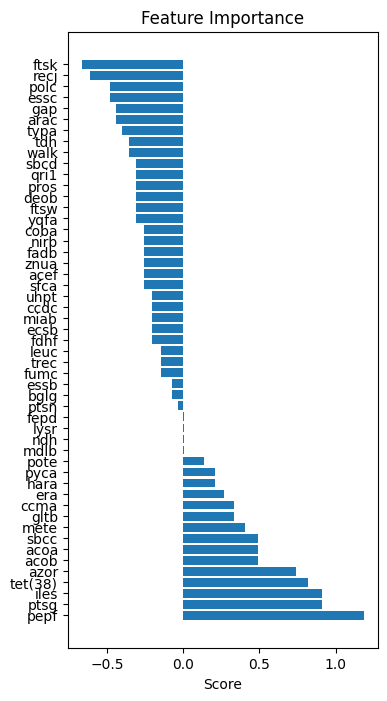

In [52]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [53]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.2833333333333333
Balanced Accuracy:  0.47334917671023596
Average Precision:  0.2296454387858568
F1 Score:  0.3582089552238806
ROC AUC:  0.47334917671023596


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7611111111111111
Balanced Accuracy:  0.5
Average Precision:  0.2388888888888889
F1 Score:  0.0
ROC AUC:  0.5


In [56]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
13,essc,-0.912792
32,polc,-0.912792
20,gap,-0.854158
46,typa,-0.789641
34,pros,-0.637804
38,qri1,-0.637804
18,ftsw,-0.637804
49,yqfa,-0.637804
26,mdlb,-0.590107
25,lysr,-0.590107


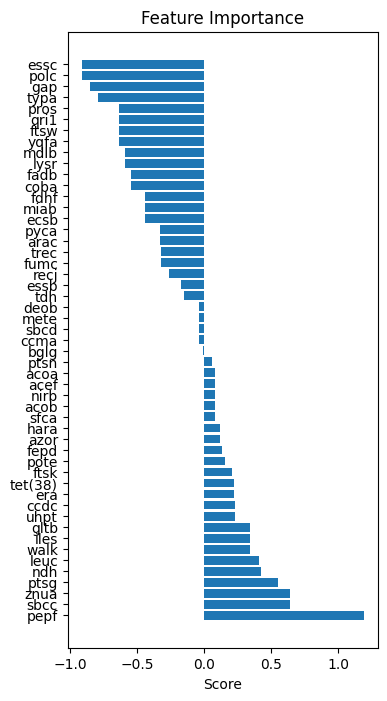

In [57]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(4, 8))

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [58]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.drop_duplicates().groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_7620/1781317332.py:4: FutureWarning: The provided callable <function sum at 0x788a541343a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.drop_duplicates().groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,AAAAAA,0.031420
1,AAAAAAA,0.890293
2,AAAAAAT,0.229920
3,AAAAAATTA,0.044526
4,AAAAACAA,0.977716
...,...,...
1274,TTTTGTTTT,0.027434
1275,TTTTTAA,0.488804
1276,TTTTTCA,2.610451
1277,TTTTTCT,0.153875


In [59]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
23,1,13080,13084,TTTGT,0.014794,yfho,lipoteichoic acid-specific glycosyltransferase YfhO,AH20I016
30,1,43186,43191,CAATAA,0.015891,rimp,ribosome maturation factor RimP,AH20I016
33,1,44362,44366,CCAGT,0.012659,nusa,Transcription antitermination factor NusA%2C contains S1 and KH domains,AH20I016
37,1,102681,102686,AAACAT,0.013746,cls,cardiolipin synthase,AH20I016
...,...,...,...,...,...,...,...,...
209167,3,312909,312914,TAATTT,0.015043,mepa,multidrug efflux MATE transporter MepA,AH20L076
209172,3,313125,313131,AATGTTT,0.015912,mepa,multidrug efflux MATE transporter MepA,AH20L076
209174,3,313171,313176,CAATTT,0.025049,mepa,multidrug efflux MATE transporter MepA,AH20L076
209177,3,313529,313533,ATGGT,0.019383,mepa,multidrug efflux MATE transporter MepA,AH20L076


In [60]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
23,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30,AH20I016,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,AH20I016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,AH20I016,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208978,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
208981,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
208982,ALF23C174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
208983,ALF23C174,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [61]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1767,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1768,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1769,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [62]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,...,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
death_30_day,0.605030,1.000000,0.004422,-0.000805,0.006119,0.006119,0.002749,0.011363,0.002749,0.007841,...,-0.000805,-0.002454,-0.018515,0.017135,0.002749,0.000866,-0.002454,-0.002454,0.002164,-0.000805
death_7_day,1.000000,0.605030,0.009005,0.010077,0.010077,0.010077,0.007949,0.013392,0.007949,0.011166,...,0.000378,0.009005,-0.017255,0.021788,0.007949,0.011166,-0.000625,-0.000625,-0.009668,0.010077
GGTCT,0.021788,0.017135,-0.036440,-0.036161,-0.036161,-0.036161,-0.036718,-0.035311,-0.036718,-0.035879,...,-0.036161,-0.036440,-0.035596,1.000000,-0.036718,-0.035879,-0.036440,-0.036440,-0.033256,-0.036161
CAATAA,0.013392,0.011363,-0.038692,-0.038395,-0.038395,-0.038395,-0.038987,1.000000,-0.038987,-0.038096,...,-0.038395,-0.038692,-0.037796,-0.035311,-0.038987,-0.038096,-0.038692,-0.038692,-0.035311,-0.038395
CACCGT,0.011166,0.007841,-0.039315,-0.039013,-0.039013,-0.039013,-0.039615,-0.038096,-0.039615,1.000000,...,-0.039013,-0.039315,-0.038404,-0.035879,-0.039615,-0.038710,-0.039315,-0.039315,-0.035879,-0.039013
AACAC,0.010077,0.006119,-0.039623,-0.039319,1.000000,-0.039319,-0.039925,-0.038395,-0.039925,-0.039013,...,-0.039319,-0.039623,-0.038705,-0.036161,-0.039925,-0.039013,-0.039623,-0.039623,-0.036161,-0.039319
AATGTTT,0.010077,0.006119,-0.039623,-0.039319,-0.039319,1.000000,-0.039925,-0.038395,-0.039925,-0.039013,...,-0.039319,-0.039623,-0.038705,-0.036161,-0.039925,-0.039013,-0.039623,-0.039623,-0.036161,-0.039319
AAAATGT,0.009005,0.004422,1.000000,-0.039623,-0.039623,-0.039623,-0.040234,-0.038692,-0.040234,-0.039315,...,-0.039623,-0.039930,-0.039004,-0.036440,-0.040234,-0.039315,-0.039930,-0.039930,-0.036440,-0.039623
CCAGT,0.009005,0.004422,-0.039930,-0.039623,-0.039623,-0.039623,-0.040234,-0.038692,-0.040234,-0.039315,...,-0.039623,-0.039930,-0.039004,-0.036440,-0.040234,-0.039315,-0.039930,-0.039930,-0.036440,-0.039623
ATGGT,0.007949,0.002749,-0.040234,-0.039925,-0.039925,-0.039925,1.000000,-0.038987,-0.040541,-0.039615,...,-0.039925,-0.040234,-0.039302,-0.036718,-0.040541,-0.039615,-0.040234,-0.040234,-0.036718,-0.039925


### Plot correlations as a heatmap

<Axes: >

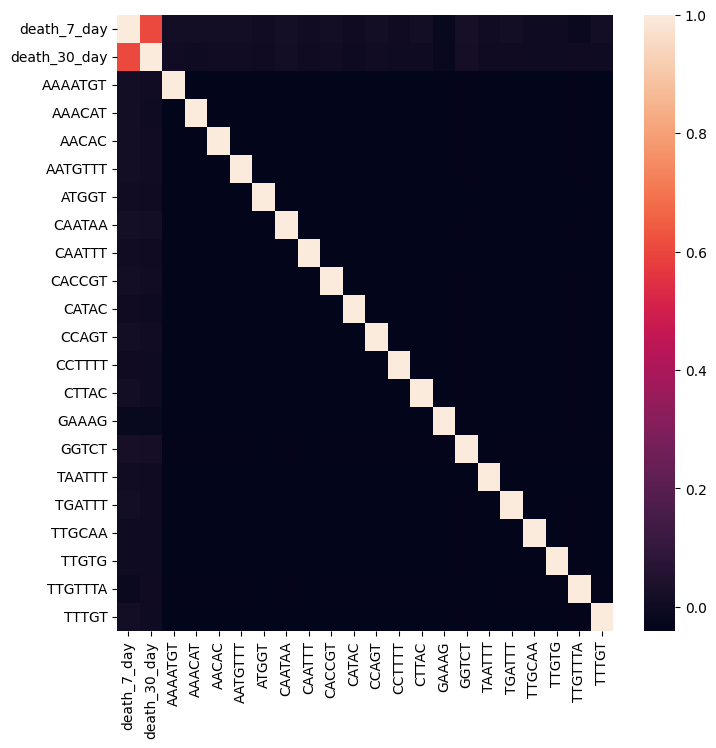

In [63]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

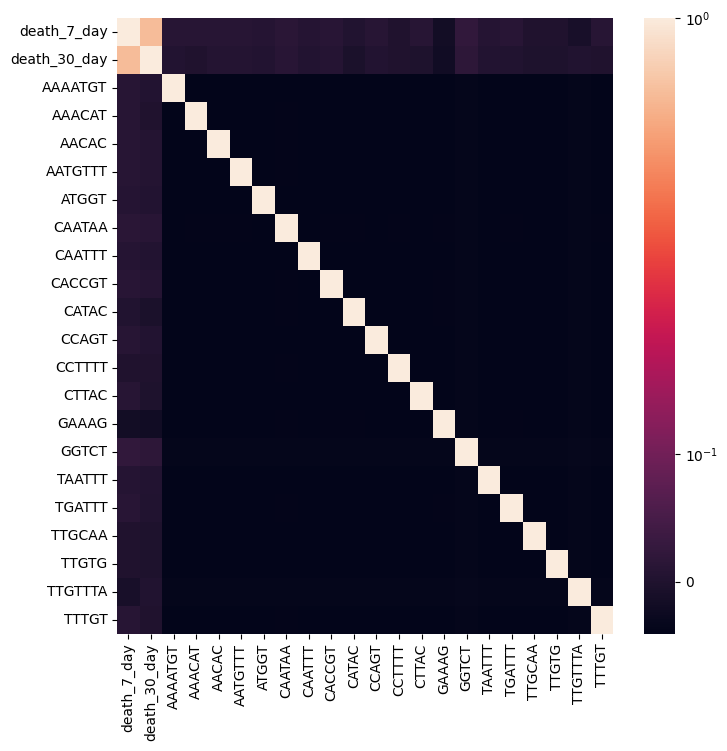

In [64]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

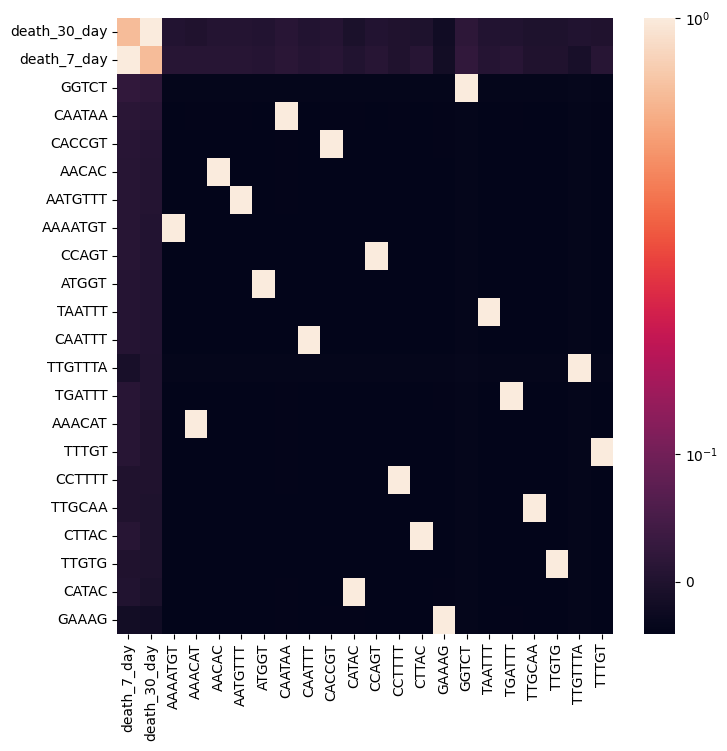

In [65]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [66]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.6169014084507042
Balanced Accuracy:  0.4380707288726548
Average Precision:  0.09928081880015086
F1 Score:  0.10526315789473684
ROC AUC:  0.43807072887265486


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8929577464788733
Balanced Accuracy:  0.5
Average Precision:  0.10704225352112676
F1 Score:  0.0
ROC AUC:  0.5


In [69]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
18,TTGTTTA,-0.297879
10,CCTTTT,-0.145971
16,TTGCAA,0.009118
12,GAAAG,0.009118
9,CCAGT,0.073020
11,CTTAC,0.107199
1,AAACAT,0.107199
17,TTGTG,0.193290
7,CACCGT,0.226771
3,AATGTTT,0.261783


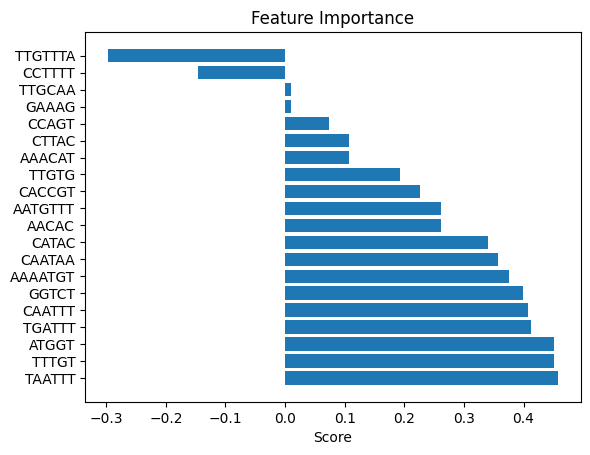

In [70]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [71]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'ATGGT'][['gene']].value_counts()[:20]

gene
ecsb    246
sfca    130
leuc    114
gltb    112
accd    101
sers     97
tdh      94
fumc     85
topa     79
bglg     77
polc     74
acef     74
acob     71
rnj1     60
rlmb     57
thra     54
pyca     52
essb     51
ftsk     49
recx     44
Name: count, dtype: int64

### Model using machine learning (30 day)

In [72]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.5549295774647888
Balanced Accuracy:  0.40967839543529005
Average Precision:  0.22623544333790968
F1 Score:  0.12222222222222222
ROC AUC:  0.40967839543529005


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7577464788732394
Balanced Accuracy:  0.5
Average Precision:  0.24225352112676057
F1 Score:  0.0
ROC AUC:  0.5


In [75]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
12,GAAAG,-0.407261
1,AAACAT,-0.069555
11,CTTAC,-0.069555
10,CCTTTT,-0.035586
16,TTGCAA,-0.005788
18,TTGTTTA,-0.000028
5,CAATAA,0.024411
4,ATGGT,0.054223
13,GGTCT,0.075413
9,CCAGT,0.080343


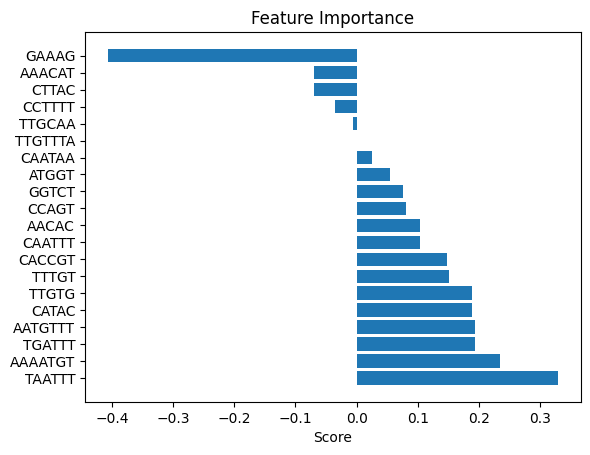

In [76]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

In [77]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'GAAAG'][['gene']].value_counts()[:20]

gene
fadb    94
oppa    65
acef    65
spa     51
glcb    45
mete    43
tdcb    41
dnae    39
polc    31
dnaj    29
sbcc    29
asd     29
aroe    28
paaj    27
ptsg    25
recj    25
ptsn    24
rbsk    22
metf    22
walk    21
Name: count, dtype: int64

In [78]:
highscoreTokenOverlapsDf[(highscoreTokenOverlapsDf.tokens == 'GAAAG') & (highscoreTokenOverlapsDf.gene == 'fadb')].groupby('tube_code').agg({'contig_id': 'count'}).reset_index().rename(columns={'contig_id': 'count'}).sort_values(by='count', ascending=False)

,tube_code,count
1,AH18L036,7
4,AH19B014,7
6,AH19E041,7
10,AH20C072,7
17,AH20L088,7
24,ALF22E113,7
16,AH20K061,7
2,AH18L078,5
29,ALF22L078,5
0,AH18J075,5
